In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import pickle

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
LOCAL = False

if LOCAL:
    df = pd.read_csv('Final_df.csv')
    
else:
    df = pd.read_csv("/content/gdrive/My Drive/capstone project/modified datasets/Final_df_2.csv")


In [6]:
df

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,Tweet_volume,Avg_score,sum_followers,sum_prof
Date,,,,,,,,,,,,
2021-02-05,0,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402,1694.0,0.146160,7.683060e+06,0.0
2021-02-06,1,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653,3278.0,0.150722,1.657918e+07,0.0
2021-02-07,2,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143,3030.0,0.155368,1.203219e+07,0.0
2021-02-08,3,2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687,5647.0,0.171374,4.810007e+07,0.0
2021-02-09,4,2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886,4350.0,0.166602,3.187073e+07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-12,431,2022-04-12,39533.714844,40617.585938,39388.328125,40127.183594,40127.183594,30991500854,NaN,NaN,NaN,NaN
2022-04-13,432,2022-04-13,40123.570312,41430.054688,39712.746094,41166.730469,41166.730469,27691105228,18397.0,0.271014,9.560678e+07,0.0
2022-04-14,433,2022-04-14,41160.218750,41451.480469,39695.746094,39935.515625,39935.515625,24342001973,27676.0,0.271814,1.730912e+08,0.0


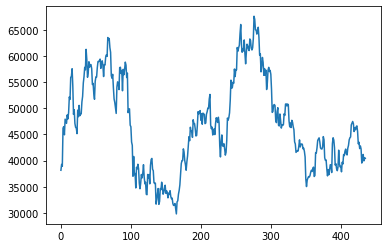

In [ ]:
df['Close'].plot()

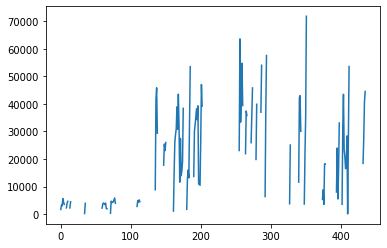

In [ ]:
df['Tweet_volume'].plot()

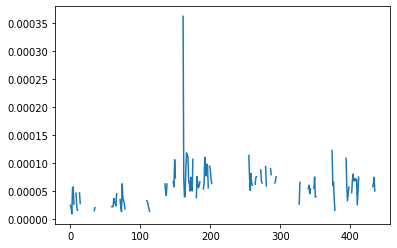

In [ ]:
df['Avg_score'].plot()

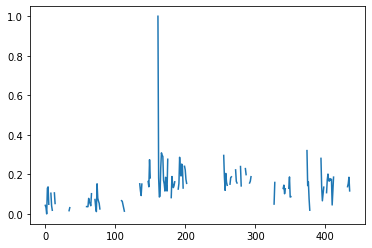

In [ ]:
df['Avg_score_norm'].plot()

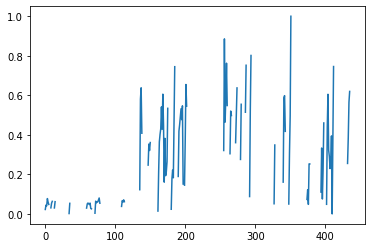

In [ ]:
df['Tweet_volume_norm'].plot()

In [7]:
df.index=pd.to_datetime(df['Date'],format='%Y-%m-%d')

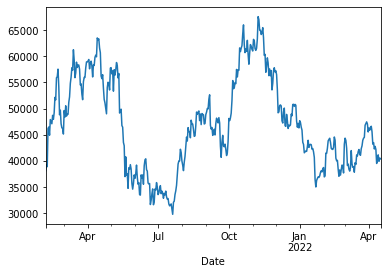

In [ ]:
df['Close'].plot()

In [8]:
# interpolate missing values 

df.interpolate(method='time', inplace=True)

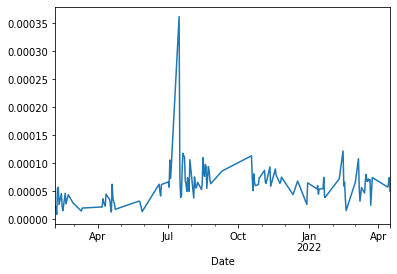

In [ ]:
df['Avg_score'].plot()

In [9]:
train_df = df[:int(.7*len(df))]
test_df = df[int(.7*len(df)):]

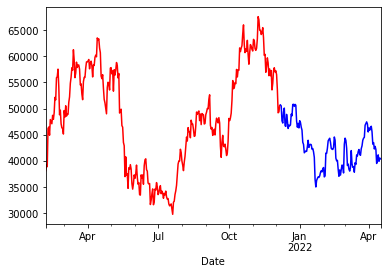

In [10]:
train_df['Close'].plot(color='red')
test_df['Close'].plot(color='blue')

In [11]:
#features & target for the model

features = ['Open', 'High', 'Low', 'Volume']
target = ['Close']

In [12]:
#features & target for the model
featureScaler = StandardScaler()
targetScaler = StandardScaler()

featureScaler.fit(train_df[features])
targetScaler.fit(train_df[target])

StandardScaler()

In [13]:
featureScaler.mean_

array([4.87576764e+04, 5.01165990e+04, 4.72002390e+04, 4.62037701e+10])

In [14]:
def create_dataset(train, test):
    
    trainX = featureScaler.transform(train[features])
    trainY = targetScaler.transform(train[target])
    
    testX = featureScaler.transform(test[features])
    testY = targetScaler.transform(test[target])
    
    X_train = np.array(trainX)
    Y_train = np.array(trainY)
    
    X_test = np.array(testX)
    Y_test = np.array(testY)

    return (trainX, trainY), (testX,testY)    

In [15]:
WINDOW_SIZE = 10

(X_train, Y_train), (X_test, Y_test) = create_dataset(train_df, test_df)

In [ ]:
print(X_train)

[[-1.22084717 -1.22189406 -1.09581533  0.50065274 -1.05421442 -0.81459077]
 [-1.09626144 -0.95259561 -0.94200427  1.01478371 -0.94618561 -0.89660474]
 [-0.98148647 -1.07844757 -1.01396392  0.77947396 -0.96309921 -1.14576419]
 ...
 [ 0.51308905  0.38926523 -0.44966019  0.61325494  0.88096531 -0.06720003]
 [ 0.04581927 -0.03580697  0.06832366 -0.36376916  0.64650278 -0.11235794]
 [ 0.06770064  0.08353615  0.00839898 -0.3432044   0.41204025 -0.15751586]]


In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(305, 8) (305, 1)
(131, 8) (131, 1)


In [16]:
# Logistic Regression baseline model

regressor = LinearRegression()

In [17]:
# for logistic regression, we will have to flatten the time dimension so that the data will be 2D (N, 10*7)
# so the model will have 70 inputs and 1 output

#train
regressor.fit(X_train,Y_train)

LinearRegression()

In [18]:
#test
predictions = regressor.predict(X_test)

loss = mse(predictions,Y_test)

print(f'MSE for Logistic Regression Baseline : {loss}')


MSE for Logistic Regression Baseline : 0.0037918329459027448


In [ ]:
pickle.dump(regressor, open('regressor.pkl', 'wb'))
pickle.dump(featureScaler, open('featureScaler.pkl', 'wb'))
pickle.dump(targetScaler, open('targetScaler.pkl', 'wb'))

In [19]:
def plot_predictions(predictions):
    #inverse scale the predictions
    predictions = targetScaler.inverse_transform(predictions)
    #predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]
    predictions = pd.DataFrame(predictions.reshape(-1).tolist(), index=test_df.index)[0]
    
    train_df['Close'].plot(color='red')
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')
    
def compare_pred(predictions):
    predictions = targetScaler.inverse_transform(predictions)
    #predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]

    predictions = pd.DataFrame(predictions.reshape(-1).tolist(), index=test_df.index)[0]
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')

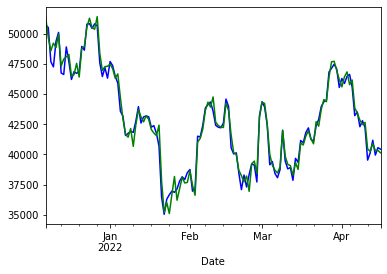

In [20]:
compare_pred(predictions)

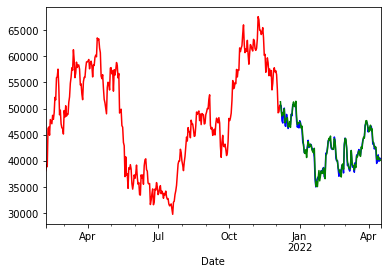

In [21]:
plot_predictions(predictions)

In [ ]:
X_train.shape, Y_train.shape

((305, 8), (305, 1))

In [ ]:
X_test.shape, Y_test.shape

((131, 8), (131, 1))

In [25]:
def calculate_r2(predictions, ground_truth):
    predictions = targetScaler.inverse_transform(predictions)
    score = r2_score(predictions, ground_truth)*100
    return score

In [24]:
# calculate R2 metrics

regressor_predictions = regressor.predict(X_test)


regressor_r2 = calculate_r2(regressor_predictions, test_df['Close'])


print(f'R2 for Linear Regression model -> {regressor_r2:.2f}%')



R2 for Linear Regression model -> 97.75%
